# LDDMM: how to register a mesh to a template?

TODO: create a how to fully emulating Nicolas' script (i.e. including registration parameters)

In [1]:
from pathlib import Path

import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
from polpo.preprocessing import Map
from polpo.preprocessing.load.pregnancy.pilot import (
    HippocampalSubfieldsSegmentationsLoader,
)
from polpo.preprocessing.mesh.conversion import PvFromData
from polpo.preprocessing.mesh.io import PvWriter
from polpo.preprocessing.mesh.registration import RigidAlignment
from polpo.preprocessing.mesh.smoothing import PvSmoothTaubin
from polpo.preprocessing.mesh.transform import MeshCenterer
from polpo.preprocessing.mri import (
    MeshExtractorFromSegmentedImage,
    MeshExtractorFromSegmentedMesh,
)

No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
SOURCE_INDEX = 3
TARGET_INDEX = 14

STRUCT_NAME = "PostHipp"

OUTPUTS_DIR = Path("results") / f"registration_{STRUCT_NAME.lower()}"
REGISTRATION_DIR = OUTPUTS_DIR / "registration"

OUTPUTS_DIR.mkdir(exist_ok=False)

## Load meshes

Following [How to get a mesh from an MRI image?](./mri2mesh.ipynb), we start by loading two selected meshes. See also [How to select a mesh subset?](./hipp_substructures.ipynb).


In [4]:
struct_from_image = True

path2img = HippocampalSubfieldsSegmentationsLoader(
    subset=[SOURCE_INDEX, TARGET_INDEX], as_image=True
)

if struct_from_image:
    img2mesh = MeshExtractorFromSegmentedImage(
        struct_id=STRUCT_NAME, encoding="ashs"
    ) + PvFromData(keep_colors=False)
else:
    img2mesh = (
        MeshExtractorFromSegmentedImage(struct_id=-1, encoding="ashs")
        + PvFromData()
        + MeshExtractorFromSegmentedMesh(struct_id=STRUCT_NAME, encoding="ashs")
    )

pipe = path2img + ppdict.DictMap(img2mesh) + ppdict.DictToValuesList()

In [5]:
meshes = pipe()

INFO: Data has already been downloaded... using cached file ('/home/luisfpereira/.herbrain/data/pregnancy/derivatives/segmentations').


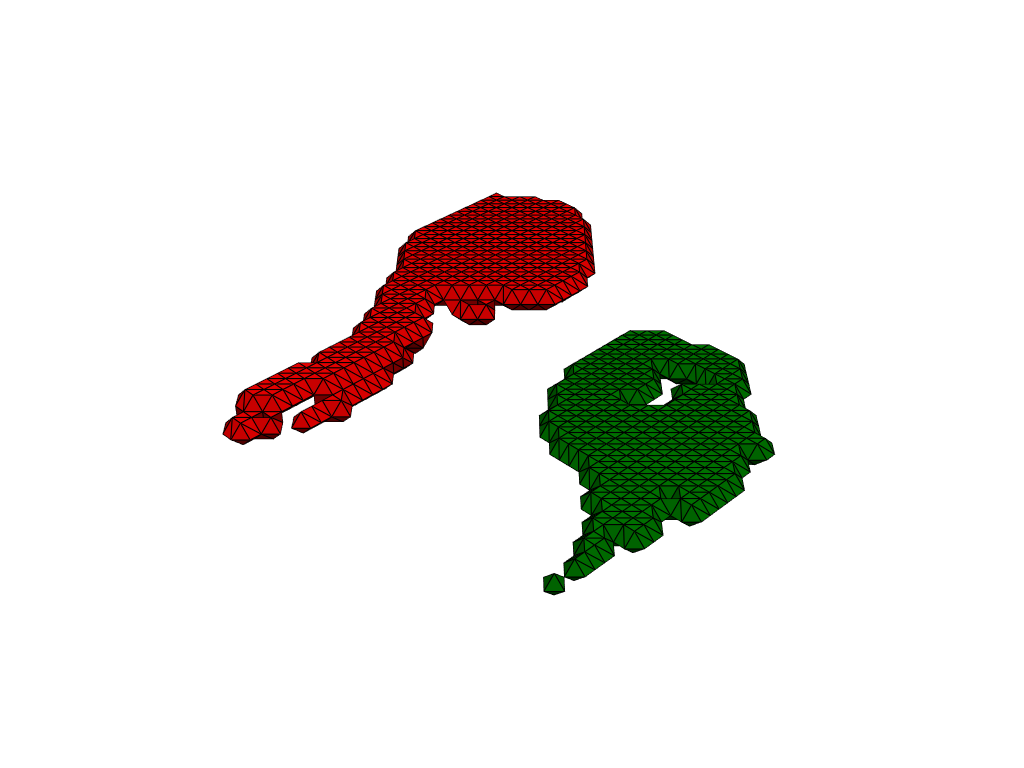

In [6]:
pl = pv.Plotter(border=False)

pl.add_mesh(meshes[0], show_edges=True, color="red")
pl.add_mesh(meshes[1], show_edges=True, color="green")

pl.show()

## Preprocessing

As we can see in the visualization, meshes are not rigid aligned. Preprocessing takes care of this kind of details, before applying LDDMM.

In [7]:
# TODO: consider decimation if above a given number of points

prep_pipe = Map(MeshCenterer() + PvSmoothTaubin(n_iter=20)) + RigidAlignment(
    max_iterations=10
)

In [8]:
meshes = prep_pipe(meshes)

[mesh.points.shape[0] for mesh in meshes]

[768, 681]

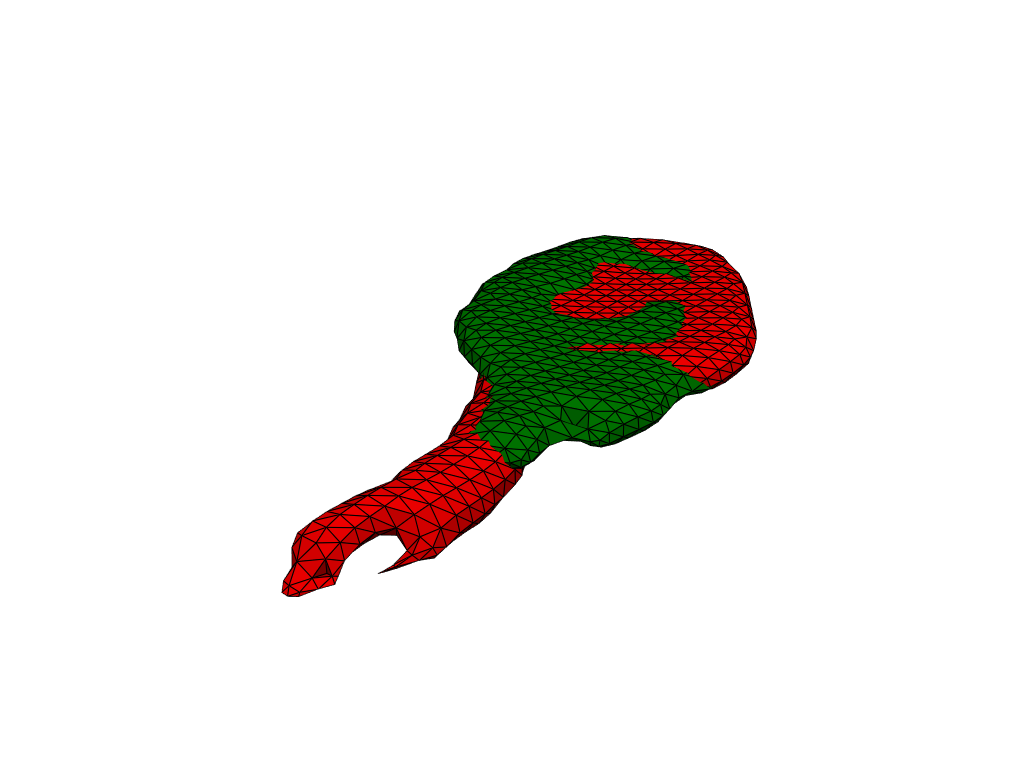

In [9]:
pl = pv.Plotter(border=False)

pl.add_mesh(meshes[0], show_edges=True, color="red")
pl.add_mesh(meshes[1], show_edges=True, color="green")

pl.show()

## LDDMM

Save meshes in `vtk` format (as required by `deformetrica`).

In [10]:
meshes_writer = Map(PvWriter(dirname=OUTPUTS_DIR, ext="vtk"))

mesh_filenames = [f"mesh_{which}" for which in ["source", "target"]]
mesh_filenames = meshes_writer(list(zip(mesh_filenames, meshes)))

Use LDDMM to register the meshes.

In [11]:
# TODO: need to adapt registration parameters to substructure
registration_kwargs = dict(
    kernel_width=10.0,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    tol=1e-16,
    attachment_kernel_width=2.0,
)

plddmm.estimate_registration(
    mesh_filenames[0],
    mesh_filenames[1],
    output_dir=REGISTRATION_DIR,
    **registration_kwargs,
)

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/registration_posthipp/registration/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
instantiating kernel torch with kernel_width 10.0 and gpu_mode GpuMode.KERNEL. addr: 0x734225952bd0
instantiating kernel torch with kernel_width 2.0 and gpu_mode GpuMode.KERNEL. addr: 0x734225952610
>> Set of 10 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

## Further reading

* [LDDMM: how to visualize registration results?](./lddmm_register_mesh_template_viz.ipynb)

* [LDDMM: how to estimate a deterministic atlas?](./lddmm_deterministic_atlas.ipynb)

* [LDDMM: how to do regression?](./lddmm_regression.ipynb)